**Summary:** Reproduce figures from BLISS paper related to the galaxy autoencoder.

In [34]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [35]:
%matplotlib inline

In [36]:
import numpy as np
import galsim
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from bliss import plotting
from bliss.models import galaxy_net
from bliss.metrics import get_single_galaxy_measurements
from bliss.datasets.sdss import convert_flux_to_mag

In [37]:
import seaborn as sns
from plot_defaults import set_rc_params, format_plot, CB_color_cycle

# Utility

In [38]:
def remove_outliers(*args, level=0.99): 
    # each arg in args should be 1D numpy.array with same number of data points.
    for arg in args: 
        assert len(arg) == len(args[0])
        assert isinstance(arg, np.ndarray)
        assert len(arg.shape) == 1
    keep = np.ones(args[0].shape).astype(bool)
    for x in args:
        x_min, x_max = np.quantile(x, 1 - level), np.quantile(x, level)
        keep_x = (x > x_min) & (x < x_max)
        keep = keep & keep_x
    
    return (arg[keep] for arg in args)

# Load data and Models

In [39]:
# load galsim images from `SDSSGalaxies` data module. 
# TODO: How to reproduce? 
data = torch.load('../../output/sdss_simulated_galaxies_figures.pt')
images = data['images']
noiseless = data['noiseless']
background = data['background'].reshape(1, 1, 53, 53)

In [40]:
# load model 
model_path = '../../models/sdss_autoencoder.ckpt'
auto_encoder = galaxy_net.OneCenteredGalaxyAE.load_from_checkpoint('../../models/sdss_autoencoder.ckpt').eval()
assert not auto_encoder.training

In [41]:
# get reconstructions and residuals
recon_mean = auto_encoder.forward(images, background).detach()
residuals = (images - recon_mean) / recon_mean.sqrt()

In [42]:
# get PSF used
psf_array = np.load('../../data/psField-000094-1-0012-PSF-image.npy')
galsim_psf_image = galsim.Image(psf_array[0], scale=0.396) # sdss scale
psf = galsim.InterpolatedImage(galsim_psf_image).withFlux(1.0)
psf_image = psf.drawImage(nx=53, ny=53, scale=0.396).array

# Autoencoder Performance Figures

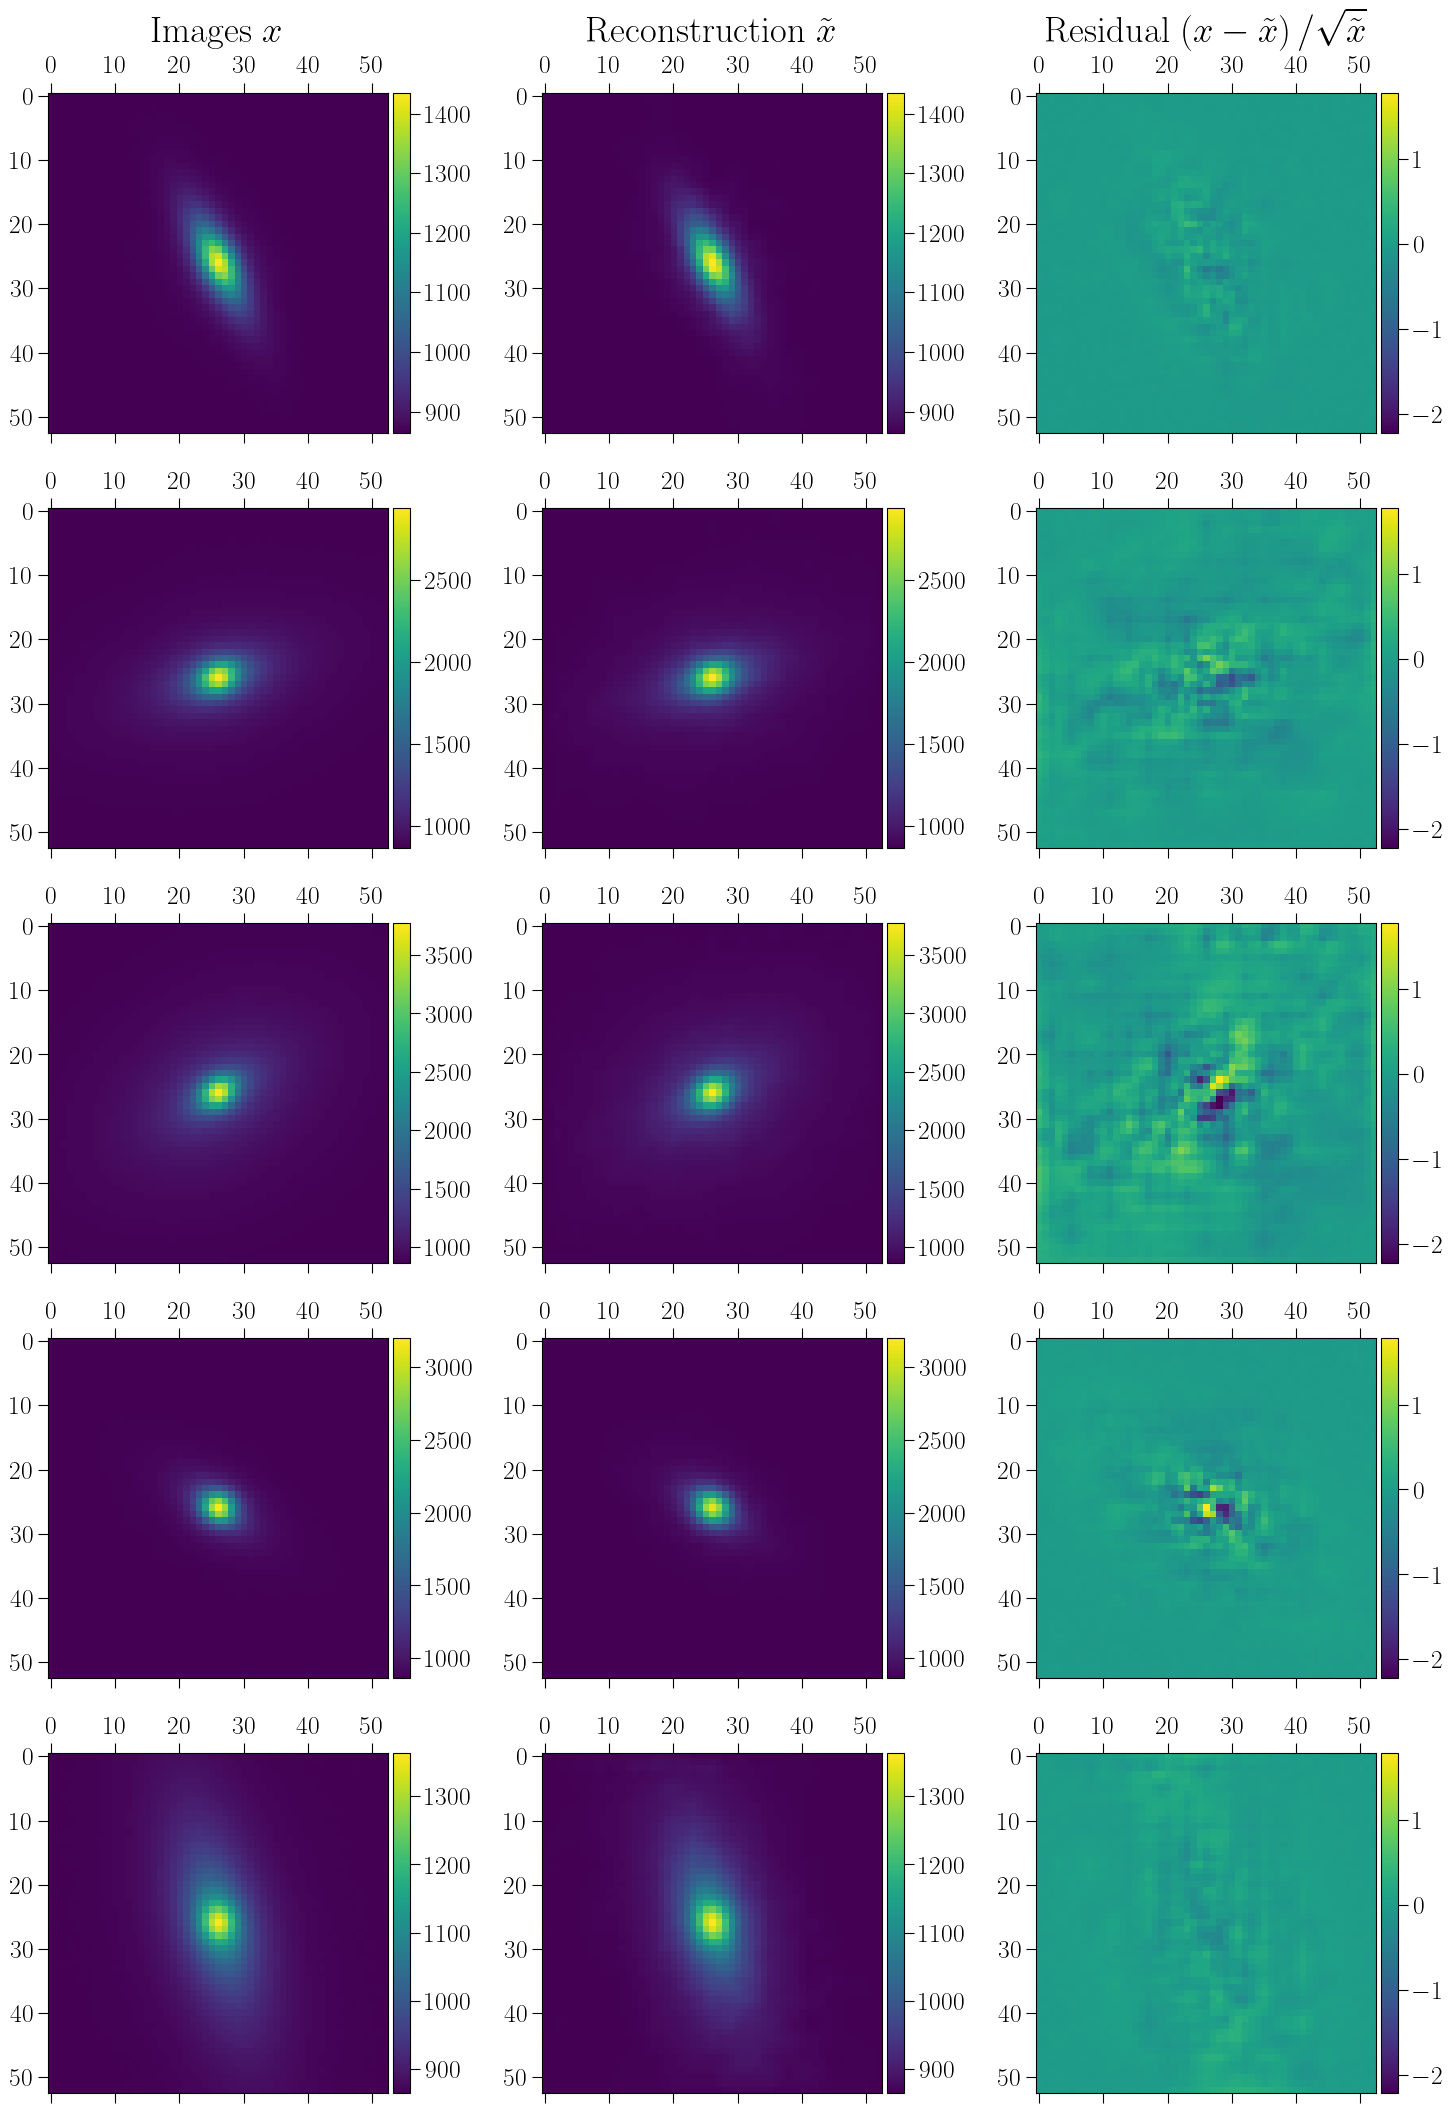

In [47]:
sns.reset_defaults()
plt.style.use("seaborn-colorblind")
set_rc_params(fontsize = 22, tick_label_size='small', legend_fontsize='small')
fig = auto_encoder.plot_reconstruction(images, recon_mean, residuals, mode='random', width=15, pad=10., 
                                       n_examples=5)
plt.subplots_adjust(hspace=-0.40)
fig

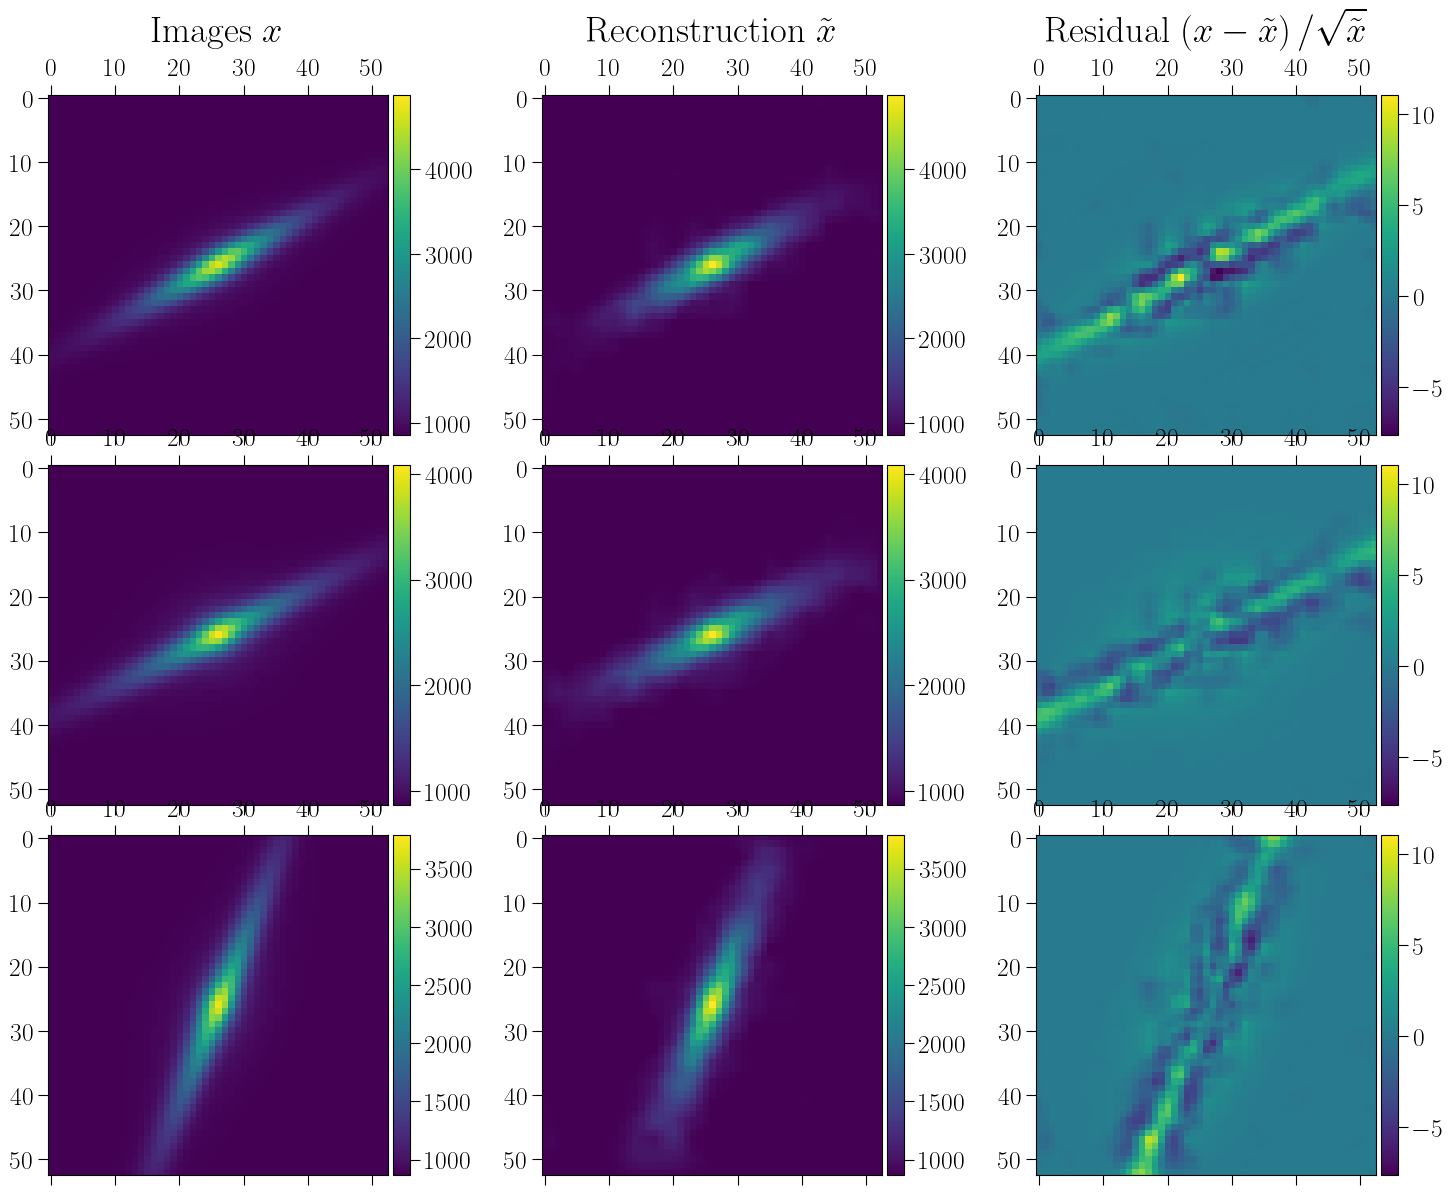

In [48]:
fig = auto_encoder.plot_reconstruction(images, recon_mean, residuals, mode='worst', width=15, pad=12., 
                                       n_examples=3)
plt.subplots_adjust(hspace=-0.40)
fig

# Single galaxy measurement comparison

In [28]:

sns.set_theme(style="darkgrid")


In [29]:
true_images = noiseless.numpy()
recon_images = (recon_mean - background.mean().item()).numpy()

In [11]:
# do measurements
measurements = get_single_galaxy_measurements(slen=53,  true_images=true_images, 
                                              recon_images=recon_images, psf_image=psf_image.reshape(-1, 53, 53), pixel_scale=0.396)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10240/10240 [00:25<00:00, 402.98it/s]


In [66]:
true_fluxes = measurements['true_fluxes']
recon_fluxes = measurements['recon_fluxes']
true_mags, recon_mags = convert_flux_to_mag(true_fluxes), convert_flux_to_mag(recon_fluxes)


true_hlrs = measurements['true_hlrs']
recon_hlrs = measurements['recon_hlrs']

true_ellip1 = measurements['true_ellip'][:, 0]
recon_ellip1 = measurements['recon_ellip'][:, 0]

true_ellip2 = measurements['true_ellip'][:, 1]
recon_ellip2 = measurements['recon_ellip'][:, 1]

## Scatter Plot with Density Contours

In [13]:
def make_scatter_hist_kde(ax, x, y, **plot_kwargs):
    sns.scatterplot(x = x, y = y, s=5, color='0.15', ax = ax)
    sns.histplot(x = x, y = y, pthresh=0.1, cmap='mako', ax = ax, cbar=True)
    sns.kdeplot(x=x, y=y, levels=5, color='w', linewidths=1, ax = ax)
    format_plot(ax, **plot_kwargs)

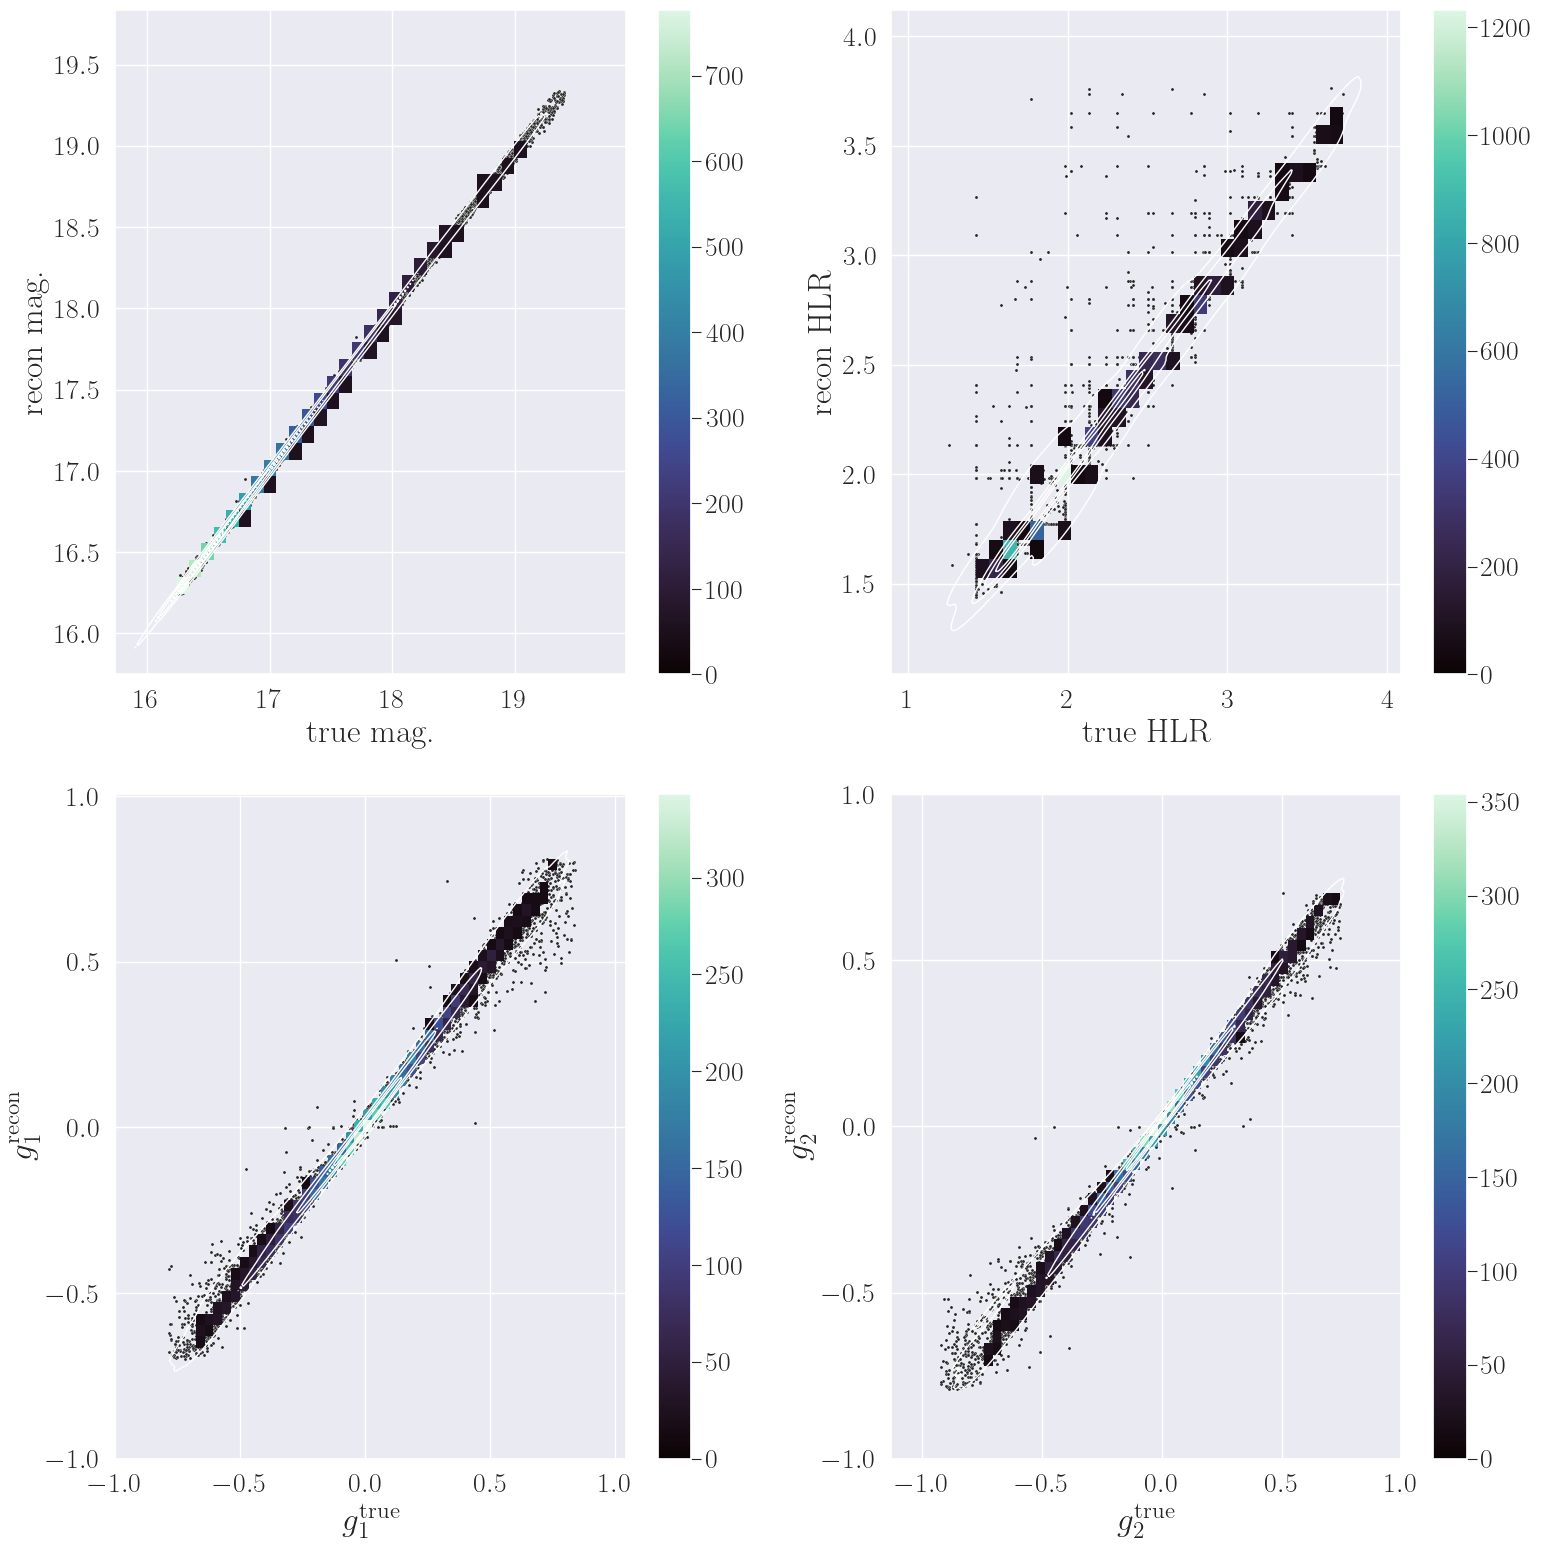

In [67]:
f, axes = plt.subplots(2, 2, figsize=(16, 16))
ax1, ax2, ax3, ax4 = axes.flatten()
set_rc_params(fontsize=24, legend_fontsize='small')

# fluxes / magnitudes
true_mags, recon_mags = convert_flux_to_mag(true_fluxes), convert_flux_to_mag(recon_fluxes)
x, y = remove_outliers(true_mags, recon_mags, level=0.95)
make_scatter_hist_kde(ax1, x, y, xlabel=r'\rm true mag.', ylabel=r'\rm recon mag.')

# hlrs
x, y = remove_outliers(true_hlrs, recon_hlrs, level=0.95)
make_scatter_hist_kde(ax2, x, y, lims=None, ticks=None, xlabel=r'\rm true HLR', 
                      ylabel=r'\rm recon HLR')

#ellipticities
x, y = remove_outliers(true_ellip1, recon_ellip1, level=0.95)
g_ticks = (-1.0, -0.5, 0.0, 0.5, 1.0)
make_scatter_hist_kde(ax3, x, y, xticks=g_ticks, yticks=g_ticks, xlabel=r'$g_{1}^{\rm true}$', 
                      ylabel=r'$g_{1}^{\rm recon}$')

x, y = remove_outliers(true_ellip2, recon_ellip2, level=0.95)
make_scatter_hist_kde(ax4, x, y, xticks=g_ticks, yticks=g_ticks, xlabel=r'$g_{2}^{\rm true}$', 
                      ylabel=r'$g_{2}^{\rm recon}$')

plt.tight_layout()

## JointPlot

In [32]:
def make_2d_hist(x, y, color='m', height=7, **plot_kwargs):
    g = sns.jointplot(x=x, y=y, color='m', kind='hist', marginal_ticks=True, ax=ax, height=height)
    g.ax_joint.axline(xy1=(np.median(x), np.median(y)), slope=1.)
    
    format_plot(g.ax_joint, **plot_kwargs)

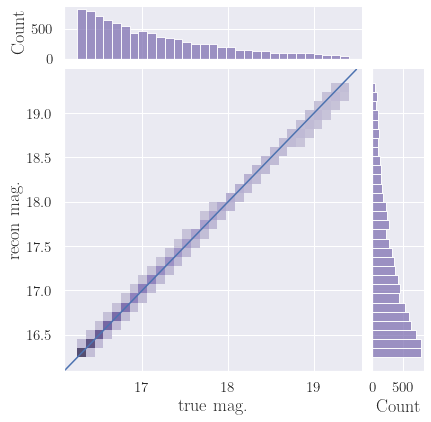

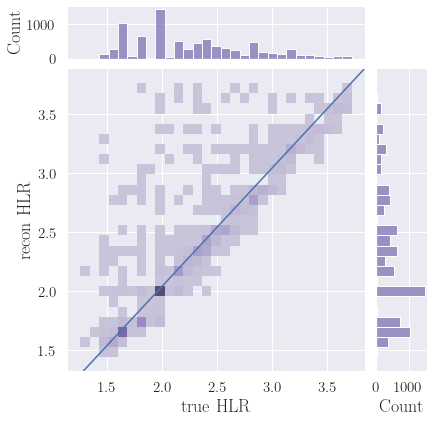

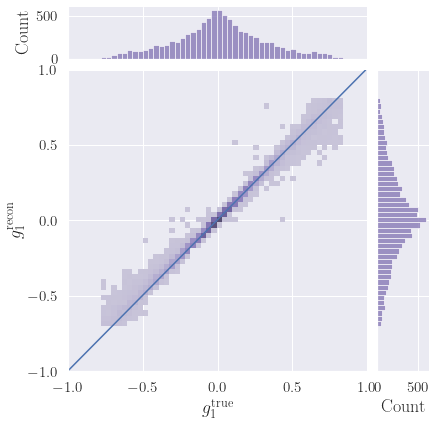

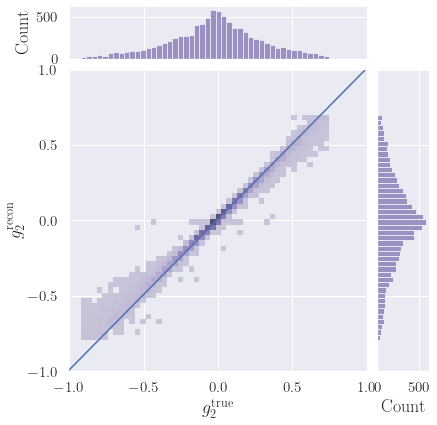

In [115]:
set_rc_params(fontsize=18)

# fluxes / magnitudes
true_mags, recon_mags = convert_flux_to_mag(true_fluxes), convert_flux_to_mag(recon_fluxes)
x, y = remove_outliers(true_mags, recon_mags, level=0.95)
make_2d_hist(x, y, xlabel=r'\rm true mag.', ylabel=r'\rm recon mag.')

# hlrs
x, y = remove_outliers(true_hlrs, recon_hlrs, level=0.95)
make_2d_hist(x, y, lims=None, ticks=None, xlabel=r'\rm true HLR', 
                      ylabel=r'\rm recon HLR')

#ellipticities
x, y = remove_outliers(true_ellip1, recon_ellip1, level=0.95)
make_2d_hist(x, y, ticks=[-1.0, -0.5, 0.0, 0.5, 1.0], xlabel=r'$g_{1}^{\rm true}$', 
                      ylabel=r'$g_{1}^{\rm recon}$')

x, y = remove_outliers(true_ellip2, recon_ellip2, level=0.95)
make_2d_hist(x, y, ticks=[-1.0, -0.5, 0.0, 0.5, 1.0], xlabel=r'$g_{2}^{\rm true}$', 
                      ylabel=r'$g_{2}^{\rm recon}$')

# Binned Residuals

In [109]:
def scatter_bin_plot(ax, x, y, xlims, delta, capsize=5.0, **plot_kwargs):


    xbins = np.arange(xlims[0], xlims[1], delta)

    xs = np.zeros(len(xbins))
    ys = np.zeros(len(xbins))
    errs = np.zeros((len(xbins), 2))
    
    
    for i, bx in enumerate(xbins):
        keep_x = (x > bx) & (x < bx + delta)
        y_bin = y[keep_x]
        
        xs[i] = bx + delta/2

        if len(y_bin)==0: 
            ys[i] = np.nan
            errs[i]= (np.nan, np.nan)
            continue
            
        ys[i] = np.median(y_bin)
        errs[i, :] = ys[i] - np.quantile(y_bin, 0.25), np.quantile(y_bin, 0.75) - ys[i]
    
    
    errs = errs.T.reshape(2, -1)
    ax.errorbar(xs, ys, yerr=errs, marker='o', c='m', linestyle='--', capsize=capsize)
    format_plot(ax, **plot_kwargs)


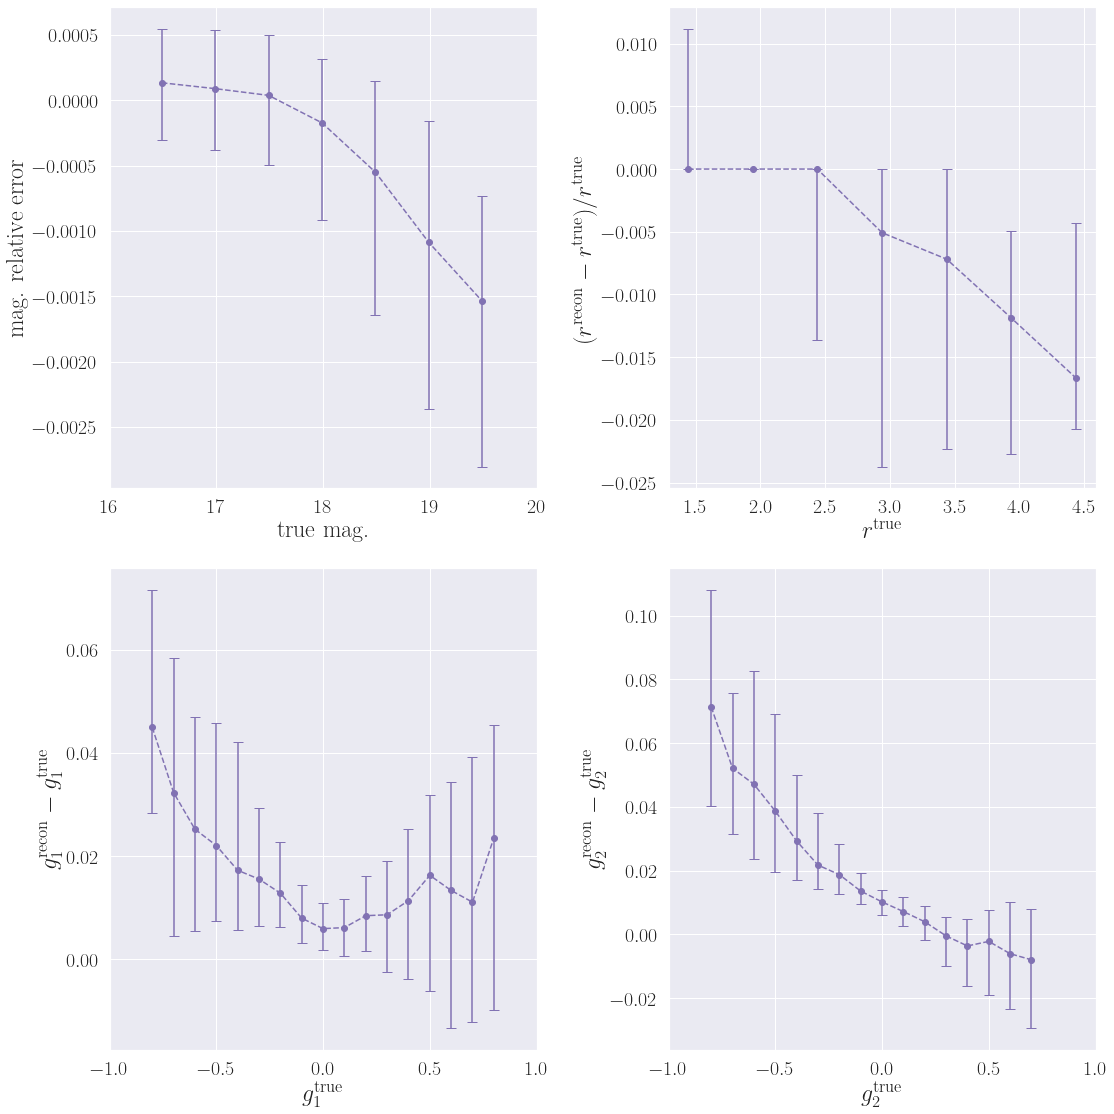

In [110]:
f, axes = plt.subplots(2, 2, figsize=(16, 16))
ax1, ax2, ax3, ax4 = axes.flatten()
set_rc_params(fontsize=24)

# fluxes / magnitudes
true_mags, recon_mags = convert_flux_to_mag(true_fluxes), convert_flux_to_mag(recon_fluxes)
x, y = remove_outliers(true_mags, (recon_mags - true_mags) / true_mags, level=0.95)
scatter_bin_plot(ax1, x, y, xlims=(x.min(), x.max()), delta=0.5, 
                 xlabel=r'\rm true mag.', ylabel=r'\rm mag. relative error', xticks=[16, 17, 18, 19, 20])

# hlrs
x, y = remove_outliers(true_hlrs, (recon_hlrs - true_hlrs) / true_hlrs, level=0.99)
scatter_bin_plot(ax2, x, y, xlims=(x.min(), x.max()), delta=0.5, 
                 xlabel=r'$r^{\rm true}$', ylabel=r'$(r^{\rm recon} - r^{\rm true}) / r^{\rm true}$')

#ellipticities
x, y = remove_outliers(true_ellip1, recon_ellip1 - true_ellip1, level=0.95)
scatter_bin_plot(ax3, x, y, xlims=(-0.85, 0.85), delta=0.1, xticks=[-1.0, -0.5, 0.0, 0.5, 1.0], xlabel=r'$g_{1}^{\rm true}$', 
                      ylabel=r'$g_{1}^{\rm recon} - g_{1}^{\rm true}$')

x, y = remove_outliers(true_ellip2, recon_ellip2 - true_ellip2, level=0.95)
scatter_bin_plot(ax4, x, y, xlims=(-0.85, 0.85), delta=0.1, xticks=[-1.0, -0.5, 0.0, 0.5, 1.0], xlabel=r'$g_{2}^{\rm true}$', 
                      ylabel=r'$g_{2}^{\rm recon} - g_{2}^{\rm true}$')

plt.tight_layout()
    